<a href="https://colab.research.google.com/github/zyntonyson/Erisk2017/blob/master/00_N_gram_Multichannel_Convolutional_Neural_Network_for_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Cargar datos 
import pandas as pd
DATA_PATH='/content/drive/My Drive/MCE/Participaciones/04.Diplomado Deep Learning/proyecto/data/'


df_train = pd.read_csv(DATA_PATH + 'train.csv', sep=',', header=0)
df_train = df_train[df_train['post'].notnull()]

df_test = pd.read_csv(DATA_PATH + 'test.csv', sep=',', header=0)
df_test = df_test[df_test['post'].notnull()]

In [0]:
#Separar datos de entrenamiento
corp_train=df_train['post'].tolist()
y_train=df_train['Depression'].tolist()


In [0]:
#Separar datos de prueba
corp_test=df_test['post'].tolist()
y_test=df_test['Depression'].tolist()

In [0]:
#Métricas

from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


Using TensorFlow backend.


In [0]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate


# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the maximum document length
def max_length(lines):
	return max([len(s.split()) for s in lines])

# encode a list of lines
def encode_text(tokenizer, lines, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(lines)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded

# define the model
def define_model(length, vocab_size):
  # channel 1
  inputs1 = Input(shape=(length,))
  embedding1 = Embedding(vocab_size, 100)(inputs1)
  conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)
  # channel 2
  inputs2 = Input(shape=(length,))
  embedding2 = Embedding(vocab_size, 100)(inputs2)
  conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)
  # channel 3
  inputs3 = Input(shape=(length,))
  embedding3 = Embedding(vocab_size, 100)(inputs3)
  conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)
  # merge
  merged = concatenate([flat1, flat2, flat3])
  # interpretation
  dense1 = Dense(10, activation='relu')(merged)
  outputs = Dense(1, activation='sigmoid')(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  # compile
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
  # summarize
  print(model.summary())
  plot_model(model, show_shapes=True, to_file=DATA_PATH+'multichannel1.png',rankdir='TB')
  plot_model(model, show_shapes=True, to_file=DATA_PATH+'multichannel2.png',rankdir='LR')
  return model


# create tokenizer
tokenizer = create_tokenizer(corp_train)
# calculate max document length
length = max_length(corp_train)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

# encode data
trainX = encode_text(tokenizer, corp_train, length)
print(trainX.shape)



Max document length: 54358
Vocabulary size: 95525
(485, 54358)


In [0]:

# define model
model = define_model(length, vocab_size)
# fit model
hist=model.fit([trainX,trainX,trainX], array(y_train), epochs=100, batch_size=16)
# save the model
#model.save(DATA_PATH+'model.h5')


W0704 22:30:28.172665 139668277467008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 22:30:28.190433 139668277467008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 22:30:28.193280 139668277467008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 22:30:28.219532 139668277467008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0704 22:30:28.227851 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 54358)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 54358)        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 54358)        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 54358, 100)   9552500     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [0]:
# encode data
testX = encode_text(tokenizer, corp_test, length)


# evaluate model on training dataset
#loss, acc = model.evaluate([trainX,trainX,trainX], array(y_train), verbose=0)
#print('Train Accuracy: %f' % (acc*100))

# evaluate model on test dataset dataset
loss, accuracy, f1_score, precision, recall = model.evaluate([testX,testX,testX], array(y_test) , verbose=0)


In [0]:
print('Test Accuracy: %f' % (accuracy*100))
print('Test Precision: %f' % (precision*100))
print('Test F1 Score: %f' % (f1_score*100))
print('Test Recall: %f' % (recall*100))

Test Accuracy: 87.000000
Test Precision: 0.000000
Test F1 Score: 0.000000
Test Recall: 0.000000


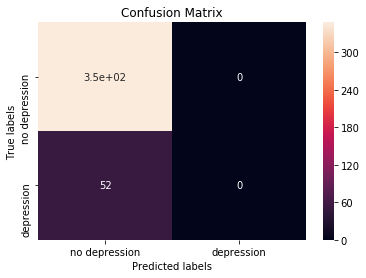

In [0]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  
import matplotlib as mpl

def select_class(x):
  if x>0.5:
    return 1
  else:
    return 0


predict_prob=model.predict([testX,testX,testX])
predict_class=[select_class(prob) for prob in predict_prob]
cm = confusion_matrix(y_test, predict_class)


# Make an example plot with two subplots...
fig2 = plt.figure()
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['no depression', 'depression']); ax.yaxis.set_ticklabels(['no depression', 'depression']);
fig2.savefig(DATA_PATH+'mc.png')


## Referencias

https://machinelearningmastery.com/what-are-word-embeddings/

https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/

https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/


How to Develop an N-gram Multichannel Convolutional Neural Network for Sentiment Analysis (Text Classification)

https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/